## Appendix 1 - Python Code and Outputs

### Data Preparation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

NOTE: extract images from zip file into train folder in the base of the current working directory of this notebook, this can be done manually or via zipfile. Example:
<pre>
import zipfile
with zipfile.ZipFile('train.zip','r') as z:
    z.extractall("train")
    print('The train dataset is extracted into the train folder of the current working directory')
</pre>

### Import Extracted Training Data

In [2]:
import os
# import extracted training files, in this case files were extracted to the train folder in my current working directory
Train_Path = "train"
train_files = os.listdir(Train_Path)

In [3]:
# number of training images
len(train_files)

# first ten image file names
train_files[0:10]

25000

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

### Extract Labels from File Names

In [4]:
import pandas as pd
import numpy as np

# extract label from file name
label = []
identifier = []
for file in train_files:
    file_name = file.split(".")
    label.append(file_name[0])
    identifier.append(file_name[1])

# create df with id and label
train_df = pd.DataFrame(data={'id':identifier,'label':label})

# dummy encode label column
train_df["label_num"] = np.where(train_df["label"] == 'cat', 1, 0)

# number of labels should be 25000
train_df.shape

# first ten rows
train_df.head(10)

(25000, 3)

,id,label,label_num
0,0,cat,1
1,1,cat,1
2,10,cat,1
3,100,cat,1
4,1000,cat,1
5,10000,cat,1
6,10001,cat,1
7,10002,cat,1
8,10003,cat,1
9,10004,cat,1


### Plot label counts

[Text(0.5, 1.0, 'Cats and Dogs')]

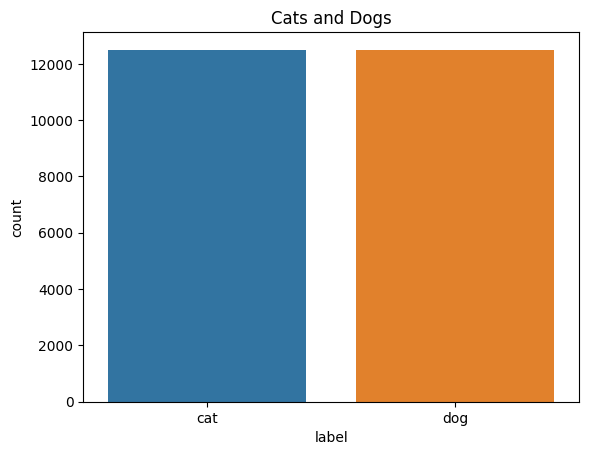

In [5]:
import seaborn as sns
import plotly as plt
sns.countplot(x=train_df.label).set(title = 'Cats and Dogs')

### Extract Image Dimensions from First 100 Training Images

In [6]:
import pandas as pd
import cv2

# loop through training files to get image dimensions
img=[]
for file in train_files[0:100]:
    count=+1
    img.append(cv2.imread(os.path.join(Train_Path,file)).shape)

# create df with dim
dim_df = pd.DataFrame(data={'dimension':img})
dim_df.head(10)

,dimension
0,"(374, 500, 3)"
1,"(280, 300, 3)"
2,"(499, 489, 3)"
3,"(499, 403, 3)"
4,"(149, 150, 3)"
5,"(359, 431, 3)"
6,"(374, 500, 3)"
7,"(471, 499, 3)"
8,"(375, 499, 3)"
9,"(239, 320, 3)"


### Import Extracted Testing Data

In [7]:
# import extracted testing files, in this case files were extracted to the test folder in my current working directory
Test_Path = "test"
test_files = os.listdir(Test_Path)

In [8]:
# number of test images
len(test_files)

# first ten image file names
test_files[0:10]

12500

['1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10004.jpg',
 '10005.jpg']

### Crop and Resize Training Images to 150x150

In [9]:
import os
from PIL import Image

# make new directory for cropped pictures
Train_Cropped_Path = "train_cropped/"
os.mkdir(Train_Cropped_Path)

# crop images and save in train_cropped folder
for file in train_files:
    im = Image.open(os.path.join(Train_Path,file))
    im = im.resize((150, 150))
    im = im.save(f"{Train_Cropped_Path}crop{file}")

#### Move cropped images to 'cat' or 'dog' folder based on label for the image data generator

In [ ]:
import shutil, sys

# image labels
categories = ['cat' , 'dog']

# function to move cat images and dog images to folders
def move_images_to_specific_folder(new_path, category):
    for image_name in os.listdir(new_path):
        if category in image_name:
            if image_name.endswith('.jpg'):
                shutil.move(os.path.join(new_path,image_name), os.path.join(new_path, category))
    
# create folders for cats and dogs
for category in categories:
    path = os.path.join(Train_Cropped_Path, category)
    os.mkdir(path)
    
# move cropped files to appropriate folder based on label
for category in categories:
    move_images_to_specific_folder(Train_Cropped_Path, category)

### Check Dimensions of Cropped Training Images

In [11]:
import shutil, sys

# loop through training files to get image dimensions
Train_Cropped_Path = "train_cropped/"

# image labels
categories = ['cat' , 'dog']

img=[]
for category in categories:
    path = os.path.join(Train_Cropped_Path, category)
    train_cropped_files = os.listdir(path)
    for file in train_cropped_files[0:10]:
        img.append(cv2.imread(os.path.join(path,file)).shape)

# create df with dimensions, all images should be 150x150
dim_cropped_df = pd.DataFrame(data={'dimension':img})
dim_cropped_df.head(10)

,dimension
0,"(150, 150, 3)"
1,"(150, 150, 3)"
2,"(150, 150, 3)"
3,"(150, 150, 3)"
4,"(150, 150, 3)"
5,"(150, 150, 3)"
6,"(150, 150, 3)"
7,"(150, 150, 3)"
8,"(150, 150, 3)"
9,"(150, 150, 3)"


The images are resized to 150x150

In [13]:
# load all libraries needed
import shutil, sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

### Use ImageDataGenerator to Prepare Training and Validation Batches

In [16]:
# create ImageDataGenerator to apply preprocessing for images and split data to batches
image_size = 150 # dimension of cropped image is 150x150
batch_size = 64 # start with relatively small batch size
epochs = 10 # start with 10 epochs

train_datagen = ImageDataGenerator(rescale = 1./255, # rescale the image pixels
                                   #rotation_range=20,
                                   validation_split=0.2, # allocate 20% of the data as validation
                                   horizontal_flip=True
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2
                                  )

train_generator = train_datagen.flow_from_directory('train_cropped/', 
                                                    class_mode='binary', 
                                                    batch_size = batch_size, 
                                                    target_size=(image_size,image_size), 
                                                    subset='training', 
                                                    shuffle=True, 
                                                    seed=10)
validation_generator = train_datagen.flow_from_directory('train_cropped/', 
                                                         class_mode='binary', 
                                                         batch_size = batch_size, 
                                                         target_size=(image_size,image_size), 
                                                         subset='validation', 
                                                         shuffle=True, 
                                                         seed=10)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


STILL WORKING ON ADJUSTING MODEL PARAMETERS - WORK IN PROGRESS

In [18]:
# Build Initial Sequential Model
model = Sequential()
# 2D convolutional layer w/64 filters, 5x5 kernel, and ReLU activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 64, kernel_size=(5,5), strides=(1,1), padding=('same'), activation="relu"))
# max pooling layer
model.add(MaxPool2D(pool_size=(2,2)))

# Conv2D and MaxPooling2D layers with 32 filters and 3x3 kernel.
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv2D and MaxPooling2D layers with 16 filters 3x3 kernel.
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# add dropout to avoid overfitting
model.add(Dropout(0.25))

# flatten output of the previous layer
model.add(Flatten())

# add dense layer
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      4864      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 16)      

In [19]:
# Adam solver optimizer with learning rate of 0.01
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
# create model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
# EarlyStopping based on validation loss (stops if model doesn't improve after 5 iterations)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# save the best model as 'best_model.cnn' based on validation loss
save_best = ModelCheckpoint(filepath = 'best_model.cnn', verbose=1, save_best_only=True)

# fit model using batches of training data and batches of testing data
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, 
                              epochs = epochs, 
                              callbacks=[save_best,early_stopping], 
                              verbose=2)

/tmp/ipykernel_3916/1036003426.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size,


Epoch 1/10


2023-05-19 12:25:28.324171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-19 12:25:29.179749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 12:25:34.179458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-19 12:25:39.730411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 12:25:39.733312: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x341eb080 in


Epoch 1: val_loss improved from inf to 0.69316, saving model to best_model.cnn


2023-05-19 12:29:17.407581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]
2023-05-19 12:29:17.744855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


312/312 - 230s - loss: 0.7250 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.5002 - 230s/epoch - 738ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.69316
312/312 - 201s - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4996 - 201s/epoch - 644ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.69316 to 0.69315, saving model to best_model.cnn


2023-05-19 12:35:59.668427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]
2023-05-19 12:35:59.885806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


312/312 - 201s - loss: 0.6934 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.5000 - 201s/epoch - 645ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.69315
312/312 - 195s - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4998 - 195s/epoch - 625ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.69315
312/312 - 205s - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4994 - 205s/epoch - 656ms/step
Epoch 6/10

Epoch 6: val_loss improved from 0.69315 to 0.69315, saving model to best_model.cnn


2023-05-19 12:46:06.952901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]
2023-05-19 12:46:07.195861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18,18,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


312/312 - 208s - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.5000 - 208s/epoch - 666ms/step
Epoch 7/10

Epoch 7: val_loss did not improve from 0.69315
312/312 - 205s - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6935 - val_accuracy: 0.5002 - 205s/epoch - 656ms/step
Epoch 8/10

Epoch 8: val_loss did not improve from 0.69315
312/312 - 174s - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6936 - val_accuracy: 0.5002 - 174s/epoch - 559ms/step
Epoch 9/10

Epoch 9: val_loss did not improve from 0.69315
312/312 - 163s - loss: 0.6933 - accuracy: 0.4941 - val_loss: 0.6933 - val_accuracy: 0.5002 - 163s/epoch - 521ms/step
Epoch 10/10

Epoch 10: val_loss did not improve from 0.69315
312/312 - 195s - loss: 0.6933 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.5002 - 195s/epoch - 625ms/step


Text(0.5, 0, 'Epoch')

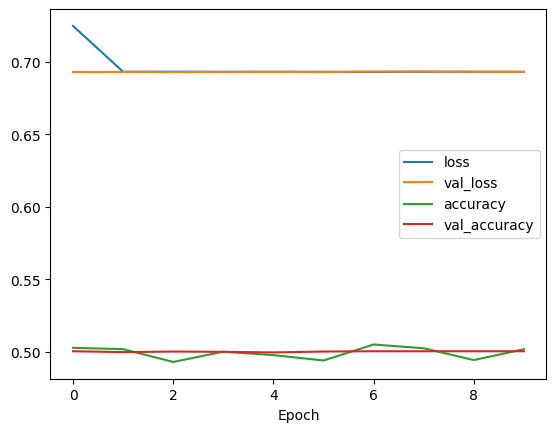

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      4864      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 16)      

In [22]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.legend()
plt.show()

best_model = tf.keras.models.load_model('best_model.cnn')
best_model.summary()

### Crop and Resize Testing Images to 150x150

In [36]:
# make new directory for cropped images
Test_Cropped_Path = "test_cropped/"
os.mkdir(Test_Cropped_Path)

# crop images and save in train_cropped folder
for file in test_files:
    im = Image.open(os.path.join(Test_Path,file))
    im = im.resize((150, 150))
    im = im.save(f"{Test_Cropped_Path}{file}")

test_cropped_files = os.listdir(Test_Cropped_Path)
test_df = pd.DataFrame(data = test_cropped_files, columns = ['filename'])
test_df['id'] = test_df['filename'].apply(lambda f: int(f.split('.')[0]))
test_df.sort_values(by = 'id', inplace = True, ignore_index = True)
test_df.head()

In [25]:
test_generator

### Input Test Data into Testing Generator for Model Predictions

In [24]:
# rescale image pixels
test_gen = ImageDataGenerator(rescale = 1./255)
# create test generator for testing data
test_generator = test_gen.flow_from_dataframe(test_df, 
                                               directory='test_cropped/', 
                                               x_col='filename',
                                               class_mode= None,
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               shuffle=False
)

Found 12500 validated image filenames.


### Save Predictions into CSV file for Kaggle

In [32]:
cnn_pred1

array([[0.5008839],
       [0.5008839],
       [0.5008839],
       ...,
       [0.5008839],
       [0.5008839],
       [0.5008839]], dtype=float32)

In [30]:
# Apply the cnn model1 to the test dataset
cnn_pred1 = best_model.predict(test_generator, steps=test_generator.samples // batch_size, verbose = 1)
y_pred_classes = ['cat' if element < 0.5 else 'dog' for element in cnn_pred1]

# Put the label predictions into a dataframe
cnn_pred1_df = pd.DataFrame(y_pred_classes, columns=['Label'])

# Add the ID column to the front of the cnn predictions dataframe
cnn_pred1_df.insert(0, 'ImageId', test_df['id'])

# Output predictions to csv
cnn_pred1_df.to_csv('test_predictions_cnn_v1.csv', index=False)

2023-05-19 13:06:57.258963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


195/195 [==============================] - 87s 445ms/step


Let's display the Kaggle results from the application of the CNN model on the test dataset

In [ ]:
# Display the kaggle results associated with the MLP Classifier Model
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
kaggle_results = plt.imread('Kaggle_results_cnn_v1.jpg')
plt.imshow(kaggle_results)
plt.axis("off")
plt.show()